In [1]:
!pip install -qU torch==1.7.1 torchvision==0.8.2
!pip install -q mmcv-full==1.3.8 -f https://download.openmmlab.com/mmcv/dist/cu102/torch1.7.0/index.html
!pip install -q mmdet==2.13

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchmetrics 0.11.4 requires torch>=1.8.1, but you have torch 1.7.1 which is incompatible.
pytorch-lightning 1.9.4 requires torch>=1.10.0, but you have torch 1.7.1 which is incompatible.
kornia 0.6.11 requires torch>=1.9.1, but you have torch 1.7.1 which is incompatible.


In [2]:
from mmdet.apis import init_detector, inference_detector
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import math
import cv2

In [3]:
!git clone -q https://github.com/hysts/pytorch_D-RISE
!wget -q https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_2x_coco/faster_rcnn_r50_fpn_2x_coco_bbox_mAP-0.384_20200504_210434-a5d8aa15.pth

In [4]:
config = 'pytorch_D-RISE/mmdet_configs/configs/faster_rcnn/faster_rcnn_r50_fpn_2x_coco.py'
checkpoint = 'faster_rcnn_r50_fpn_2x_coco_bbox_mAP-0.384_20200504_210434-a5d8aa15.pth'
device = 'cuda:0'

In [5]:
model = init_detector(config, checkpoint, device)

Use load_from_local loader


In [6]:
label_names = [
    'person',
    'bicycle',
    'car',
    'motorcycle',
    'airplane',
    'bus',
    'train',
    'truck',
    'boat',
    'traffic light',
    'fire hydrant',
    'stop sign',
    'parking meter',
    'bench',
    'bird',
    'cat',
    'dog',
    'horse',
    'sheep',
    'cow',
    'elephant',
    'bear',
    'zebra',
    'giraffe',
    'backpack',
    'umbrella',
    'handbag',
    'tie',
    'suitcase',
    'frisbee',
    'skis',
    'snowboard',
    'sports ball',
    'kite',
    'baseball bat',
    'baseball glove',
    'skateboard',
    'surfboard',
    'tennis racket',
    'bottle',
    'wine glass',
    'cup',
    'fork',
    'knife',
    'spoon',
    'bowl',
    'banana',
    'apple',
    'sandwich',
    'orange',
    'broccoli',
    'carrot',
    'hot dog',
    'pizza',
    'donut',
    'cake',
    'chair',
    'couch',
    'potted plant',
    'bed',
    'dining table',
    'toilet',
    'tv',
    'laptop',
    'mouse',
    'remote',
    'keyboard',
    'cell phone',
    'microwave',
    'oven',
    'toaster',
    'sink',
    'refrigerator',
    'book',
    'clock',
    'vase',
    'scissors',
    'teddy bear',
    'hair drier',
    'toothbrush',
]

In [7]:
def generate_mask(image_size, grid_size, prob_thresh):
    image_w, image_h = image_size
    grid_w, grid_h = grid_size
    cell_w, cell_h = math.ceil(image_w / grid_w), math.ceil(image_h / grid_h)
    up_w, up_h = (grid_w + 1) * cell_w, (grid_h + 1) * cell_h

    mask = (np.random.uniform(0, 1, size=(grid_h, grid_w)) <
            prob_thresh).astype(np.float32)
    mask = cv2.resize(mask, (up_w, up_h), interpolation=cv2.INTER_LINEAR)
    offset_w = np.random.randint(0, cell_w)
    offset_h = np.random.randint(0, cell_h)
    mask = mask[offset_h:offset_h + image_h, offset_w:offset_w + image_w]
    return mask

In [8]:
def mask_image(image, mask):
    masked = ((image.astype(np.float32) / 255 * np.dstack([mask] * 3)) *
              255).astype(np.uint8)
    return masked

In [9]:
def iou(box1, box2):
    box1 = np.asarray(box1)
    box2 = np.asarray(box2)
    tl = np.vstack([box1[:2], box2[:2]]).max(axis=0)
    br = np.vstack([box1[2:], box2[2:]]).min(axis=0)
    intersection = np.prod(br - tl) * np.all(tl < br).astype(float)
    area1 = np.prod(box1[2:] - box1[:2])
    area2 = np.prod(box2[2:] - box2[:2])
    return intersection / (area1 + area2 - intersection)

In [10]:
def generate_saliency_map(image,
                          target_class_index,
                          target_box,
                          prob_thresh=0.5,
                          grid_size=(16, 16),
                          n_masks=5000,
                          seed=0):
    np.random.seed(seed)
    image_h, image_w = image.shape[:2]
    res = np.zeros((image_h, image_w), dtype=np.float32)
    for _ in tqdm.notebook.tqdm(range(n_masks)):
        mask = generate_mask(image_size=(image_w, image_h),
                             grid_size=grid_size,
                             prob_thresh=prob_thresh)
        masked = mask_image(image, mask)
        out = inference_detector(model, masked)
        pred = out[target_class_index]
        score = max([iou(target_box, box) * score for *box, score in pred],
                    default=0)
        res += mask * score
    return res

In [11]:
def rise_plots(image_address, target_index, prob_thresh):
    image = cv2.imread(image_address)
    scale = 600 / min(image.shape[:2])
    image = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
    
    plt.subplots(1,3, figsize=(13,5))
    plt.subplot(131)
    plt.imshow(image[:, :, ::-1])
    plt.axis("Off")
    
    out = inference_detector(model, image)
    res = image.copy()
    outputs = []
    plt.subplot(132)
    for i, pred in enumerate(out):
        for *box, score in pred:
            if score < 0.5:
                break
            box = tuple(np.round(box).astype(int).tolist())
            outputs.append([i, label_names[i], box, score])
            print(i, label_names[i], box, score)
            cv2.rectangle(res, box[:2], box[2:], (0, 255, 0), 5)
            
    plt.imshow(res[:, :, ::-1])
    plt.axis("Off")
    
    target_box = np.array(outputs[target_index][2])
    saliency_map = generate_saliency_map(image, target_class_index=outputs[target_index][0], 
                                         target_box=target_box, prob_thresh=prob_thresh, 
                                         grid_size=(16, 16), n_masks=1000)

    image_with_bbox = image.copy()
    plt.subplot(133)
    cv2.rectangle(image_with_bbox, tuple(target_box[:2]), tuple(target_box[2:]), (0, 255, 0), 5)
    plt.imshow(image_with_bbox[:, :, ::-1])
    plt.imshow(saliency_map, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.tight_layout(pad=0.5)


___
### Skis

/opt/conda/lib/python3.7/site-packages/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


30 skis (423, 55, 601, 593) 0.9358319
30 skis (575, 48, 630, 579) 0.89403665
30 skis (416, 58, 522, 511) 0.5172153


  0%|          | 0/1000 [00:00<?, ?it/s]

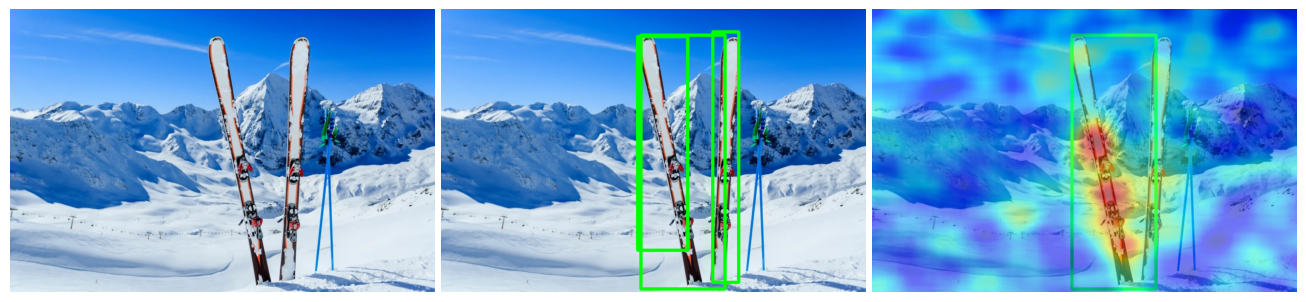

In [12]:
rise_plots(image_address = '/kaggle/input/dst-images/skis.jpg', 
           target_index = 0, 
           prob_thresh = 0.3)

___
### Donut

54 donut (41, 40, 377, 280) 0.9941105
54 donut (313, 1, 595, 166) 0.9925909
54 donut (332, 169, 600, 444) 0.98807204
54 donut (0, 197, 174, 470) 0.984916
54 donut (61, 351, 505, 717) 0.9379556
54 donut (0, 1, 133, 144) 0.8055392


  0%|          | 0/1000 [00:00<?, ?it/s]

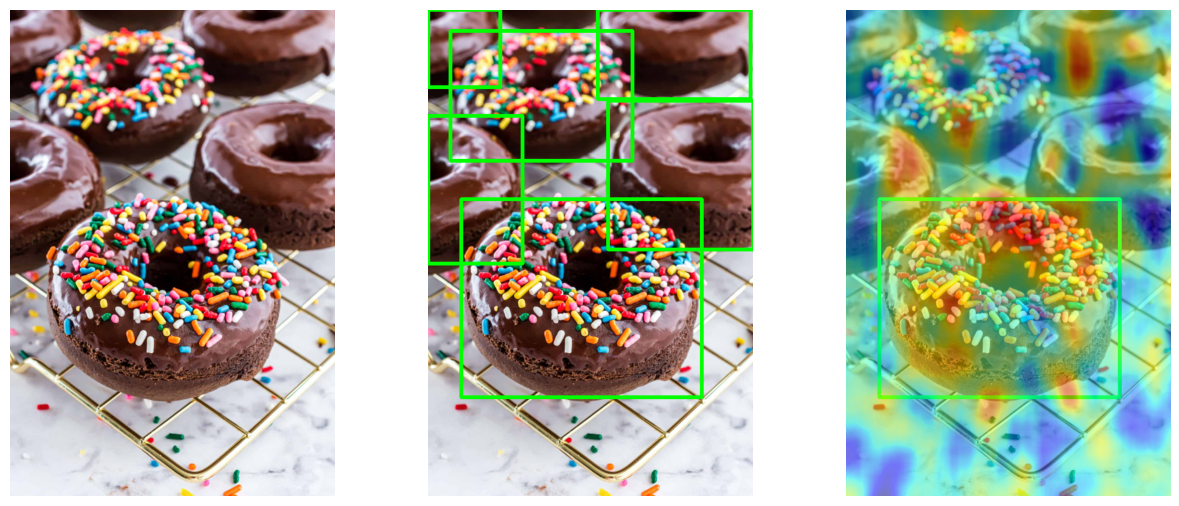

In [13]:
rise_plots(image_address = '/kaggle/input/dst-images/donut.jpg', 
           target_index = -2, 
           prob_thresh = 0.3)

___
### Teddy Bear

77 teddy bear (473, 33, 811, 486) 0.9988232


  0%|          | 0/1000 [00:00<?, ?it/s]

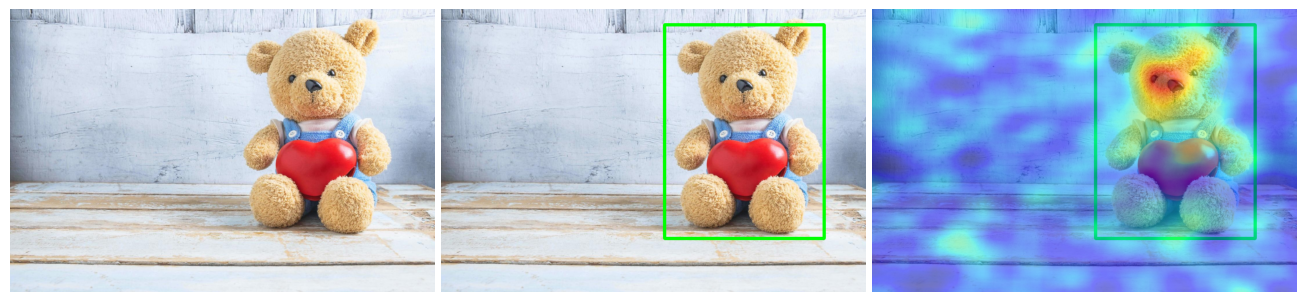

In [14]:
rise_plots(image_address = '/kaggle/input/dst-images/teddybear.jpg',
           target_index = 0,
           prob_thresh = 0.3)

---

<div align=center lang="fa"><font face="Tahoma" size="5" color=#c4c4c4>End</font></div>

---